# 1.10c: Rule Out Float32 → bfloat16 Initialization

**Goal:** Test whether f32 Gaussian initialization followed by bfloat16 quantization can produce spongecrystal-like structures.

## Hypothesis to Test

**Hypothesis 3b (f32 → bfloat16):** Model initialized in f32 with Gaussian noise, then quantized to bfloat16
- Generate 151,936 vectors as N(0, σ) in f32
- Convert to bfloat16 (quantization creates rounding/clustering)
- Random culling removes all but 2,139 tokens (simulating training)
- Prediction: Quantization clustering should produce BH-like structures

## Method

**σ sweep:** Test multiple σ values to find best match (if any)

For each σ ∈ [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01]:
1. Generate 151,936 × 2,560 matrix in f32 with N(0, σ)
2. Convert to bfloat16 (quantization step)
3. Randomly select 2,139 tokens (uniform distribution)
4. Find unique vectors and compute:
   - Total unique vectors
   - Number of BH-sized clusters (pop > 1)
   - Largest cluster population
   - Extent distribution (per dimension)
   - Number of active dimensions (extent > 0)
5. Compare to actual spongecrystal metrics

## Expected Spongecrystal Metrics

From previous analysis:
- **Unique vectors:** 52
- **BH clusters (pop > 1):** 13
- **Largest cluster:** 814 tokens
- **Cluster populations:** [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2] (irregular!)
- **Active dimensions:** 76
- **Max extent:** 55 uint16 steps (dimension 1008)
- **Extent distribution:** Most dims 0-2, three dims with 27, 32, 55

## Success Criteria

Hypothesis is **supported** if ANY σ produces:
- Unique vectors: 40-60
- BH clusters: 10-15
- Largest cluster: 500-1000 tokens
- Active dimensions: 50-100
- Max extent: 30-70 steps

Hypothesis is **ruled out** if NO σ produces spongecrystal-like structure.

## Parameters

In [9]:
# Model parameters
N_TOKENS = 151936  # Full vocabulary
N_DIMS = 2560      # Embedding dimension
N_SURVIVORS = 2139  # Tokens that survive culling (spongecrystal size)

# σ values to test (logarithmically spaced)
SIGMAS = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1]

# Random seed for reproducibility
RANDOM_SEED = 42

# Spongecrystal ground truth (from 1.9b)
SPONGE_UNIQUE_VECTORS = 52
SPONGE_N_BHS = 13
SPONGE_LARGEST_CLUSTER = 814
SPONGE_ACTIVE_DIMS = 76
SPONGE_MAX_EXTENT = 55

## Imports

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import pandas as pd

## Device Detection

In [11]:
# Detect available device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## σ Sweep Experiment

In [12]:
print("Running σ sweep experiment...\n")
print(f"Testing {len(SIGMAS)} σ values")
print(f"Generating {N_TOKENS:,} tokens × {N_DIMS:,} dims in f32")
print(f"Converting to bfloat16 (quantization step)")
print(f"Keeping {N_SURVIVORS:,} survivors after random culling")
print()

# Set random seed
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Storage for results
results = []

for sigma in tqdm(SIGMAS, desc="Testing σ values"):
    # Generate vectors in f32
    vectors_f32 = torch.randn(N_TOKENS, N_DIMS, device=device) * sigma
    
    # Convert to bfloat16 (this is the key quantization step)
    vectors_bf16 = vectors_f32.to(torch.bfloat16)
    
    # Random culling: select N_SURVIVORS tokens uniformly
    survivor_indices = torch.randperm(N_TOKENS)[:N_SURVIVORS]
    survivors = vectors_bf16[survivor_indices]
    
    # Convert to uint16 for exact comparison (move to CPU for numpy)
    survivors_uint16 = survivors.view(torch.uint16).cpu().numpy()
    
    # Find unique vectors
    unique_vectors, inverse_mapping = np.unique(survivors_uint16, axis=0, return_inverse=True)
    n_unique = len(unique_vectors)
    
    # Count populations for each unique vector
    populations = np.bincount(inverse_mapping)
    
    # Identify BH clusters (population > 1)
    bh_populations = populations[populations > 1]
    n_bhs = len(bh_populations)
    largest_cluster = populations.max() if len(populations) > 0 else 0
    
    # Compute extents per dimension
    mins_per_dim = unique_vectors.min(axis=0)
    maxs_per_dim = unique_vectors.max(axis=0)
    extents_per_dim = maxs_per_dim - mins_per_dim
    
    n_active_dims = np.sum(extents_per_dim > 0)
    max_extent = extents_per_dim.max()
    
    # Store results
    results.append({
        'sigma': sigma,
        'n_unique': n_unique,
        'n_bhs': n_bhs,
        'largest_cluster': largest_cluster,
        'n_active_dims': n_active_dims,
        'max_extent': max_extent,
        'bh_populations': sorted(bh_populations.tolist(), reverse=True),
        'extent_distribution': extents_per_dim.tolist()
    })

print("\n✓ σ sweep complete")
print(f"  Tested {len(SIGMAS)} values")

Running σ sweep experiment...

Testing 11 σ values
Generating 151,936 tokens × 2,560 dims in f32
Converting to bfloat16 (quantization step)
Keeping 2,139 survivors after random culling



Testing σ values: 100%|██████████| 11/11 [00:01<00:00, 10.06it/s]


✓ σ sweep complete
  Tested 11 values


## Results Summary

In [13]:
print("\n" + "=" * 100)
print("RESULTS SUMMARY")
print("=" * 100)
print()

# Create DataFrame for easy viewing
df = pd.DataFrame([{
    'σ': r['sigma'],
    'Unique': r['n_unique'],
    'BHs': r['n_bhs'],
    'Largest': r['largest_cluster'],
    'Active Dims': r['n_active_dims'],
    'Max Extent': r['max_extent']
} for r in results])

print("Spongecrystal ground truth:")
print(f"  Unique vectors: {SPONGE_UNIQUE_VECTORS}")
print(f"  BH clusters: {SPONGE_N_BHS}")
print(f"  Largest cluster: {SPONGE_LARGEST_CLUSTER}")
print(f"  Active dimensions: {SPONGE_ACTIVE_DIMS}")
print(f"  Max extent: {SPONGE_MAX_EXTENT}")
print()
print("Results for each σ:")
print()
print(df.to_string(index=False))
print()

# Compute match scores (closer to 1.0 = better match)
print("\nMatch scores (1.0 = perfect match to spongecrystal):")
print()

for r in results:
    # Simple scoring: geometric mean of relative errors
    unique_score = min(r['n_unique'], SPONGE_UNIQUE_VECTORS) / max(r['n_unique'], SPONGE_UNIQUE_VECTORS)
    bh_score = min(r['n_bhs'], SPONGE_N_BHS) / max(r['n_bhs'], SPONGE_N_BHS) if r['n_bhs'] > 0 else 0
    cluster_score = min(r['largest_cluster'], SPONGE_LARGEST_CLUSTER) / max(r['largest_cluster'], SPONGE_LARGEST_CLUSTER)
    dims_score = min(r['n_active_dims'], SPONGE_ACTIVE_DIMS) / max(r['n_active_dims'], SPONGE_ACTIVE_DIMS) if r['n_active_dims'] > 0 else 0
    extent_score = min(r['max_extent'], SPONGE_MAX_EXTENT) / max(r['max_extent'], SPONGE_MAX_EXTENT) if r['max_extent'] > 0 else 0
    
    overall_score = (unique_score * bh_score * cluster_score * dims_score * extent_score) ** (1/5)
    
    print(f"  σ = {r['sigma']:.4f}: {overall_score:.4f}")
    print(f"    Unique: {unique_score:.3f}, BHs: {bh_score:.3f}, Cluster: {cluster_score:.3f}, Dims: {dims_score:.3f}, Extent: {extent_score:.3f}")

# Find best match
best_idx = max(range(len(results)), key=lambda i: (
    min(results[i]['n_unique'], SPONGE_UNIQUE_VECTORS) / max(results[i]['n_unique'], SPONGE_UNIQUE_VECTORS) *
    (min(results[i]['n_bhs'], SPONGE_N_BHS) / max(results[i]['n_bhs'], SPONGE_N_BHS) if results[i]['n_bhs'] > 0 else 0) *
    min(results[i]['largest_cluster'], SPONGE_LARGEST_CLUSTER) / max(results[i]['largest_cluster'], SPONGE_LARGEST_CLUSTER) *
    (min(results[i]['n_active_dims'], SPONGE_ACTIVE_DIMS) / max(results[i]['n_active_dims'], SPONGE_ACTIVE_DIMS) if results[i]['n_active_dims'] > 0 else 0) *
    (min(results[i]['max_extent'], SPONGE_MAX_EXTENT) / max(results[i]['max_extent'], SPONGE_MAX_EXTENT) if results[i]['max_extent'] > 0 else 0)
) ** (1/5))

best = results[best_idx]
print()
print(f"Best match: σ = {best['sigma']:.4f}")
print(f"  Unique vectors: {best['n_unique']} (target: {SPONGE_UNIQUE_VECTORS})")
print(f"  BH clusters: {best['n_bhs']} (target: {SPONGE_N_BHS})")
print(f"  Largest cluster: {best['largest_cluster']} (target: {SPONGE_LARGEST_CLUSTER})")


RESULTS SUMMARY

Spongecrystal ground truth:
  Unique vectors: 52
  BH clusters: 13
  Largest cluster: 814
  Active dimensions: 76
  Max extent: 55

Results for each σ:

       σ  Unique  BHs  Largest  Active Dims  Max Extent
0.000001    2139    0        1         2560       35785
0.000003    2139    0        1         2560       35765
0.000010    2139    0        1         2560       47114
0.000030    2139    0        1         2560       47294
0.000100    2139    0        1         2560       47523
0.000300    2139    0        1         2560       47756
0.001000    2139    0        1         2560       47987
0.003000    2139    0        1         2560       48156
0.010000    2139    0        1         2560       35739
0.030000    2139    0        1         2560       35779
0.100000    2139    0        1         2560       48811


Match scores (1.0 = perfect match to spongecrystal):

  σ = 0.0000: 0.0000
    Unique: 0.024, BHs: 0.000, Cluster: 0.001, Dims: 0.030, Extent: 0.002
  σ = 

## Detailed Analysis of Best Match

In [14]:
print("\n" + "=" * 100)
print(f"DETAILED ANALYSIS: σ = {best['sigma']:.4f} (Best Match)")
print("=" * 100)
print()

# BH population comparison
print("BH cluster populations:")
print(f"  Simulated: {best['bh_populations'][:15]}")
print(f"  Actual:    [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2]")
print()

# Check if population distribution looks similar
sim_pops = np.array(best['bh_populations'][:13]) if len(best['bh_populations']) >= 13 else np.array(best['bh_populations'])
actual_pops = np.array([814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2])

if len(sim_pops) == len(actual_pops):
    # Compute correlation
    correlation = np.corrcoef(sim_pops, actual_pops)[0, 1]
    print(f"Population correlation: {correlation:.4f}")
    if correlation > 0.8:
        print("  ✓ Strong correlation - distributions are similar")
    elif correlation > 0.5:
        print("  ~ Moderate correlation")
    else:
        print("  ✗ Weak correlation - distributions differ")
else:
    print(f"  ✗ Different number of BHs ({len(sim_pops)} vs 13)")

print()

# Extent distribution analysis
extent_counts = Counter(best['extent_distribution'])
print("Extent distribution (top 10):")
for extent, count in sorted(extent_counts.items(), reverse=True)[:10]:
    print(f"  Extent {extent:3d}: {count:4d} dimensions")

print()
print(f"Spongecrystal for comparison:")
print(f"  Extent 0: 2,484 dimensions")
print(f"  Extent 1: 50 dimensions")
print(f"  Extent 2: 11 dimensions")
print(f"  Extent 55: 1 dimension (max)")


DETAILED ANALYSIS: σ = 0.0000 (Best Match)

BH cluster populations:
  Simulated: []
  Actual:    [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2]

  ✗ Different number of BHs (0 vs 13)

Extent distribution (top 10):
  Extent 35785:    1 dimensions
  Extent 35651:    1 dimensions
  Extent 35639:    1 dimensions
  Extent 35477:    1 dimensions
  Extent 35465:    1 dimensions
  Extent 35429:    1 dimensions
  Extent 35428:    1 dimensions
  Extent 35414:    1 dimensions
  Extent 35400:    1 dimensions
  Extent 35380:    1 dimensions

Spongecrystal for comparison:
  Extent 0: 2,484 dimensions
  Extent 1: 50 dimensions
  Extent 2: 11 dimensions
  Extent 55: 1 dimension (max)


## Visualizations


Creating visualizations...



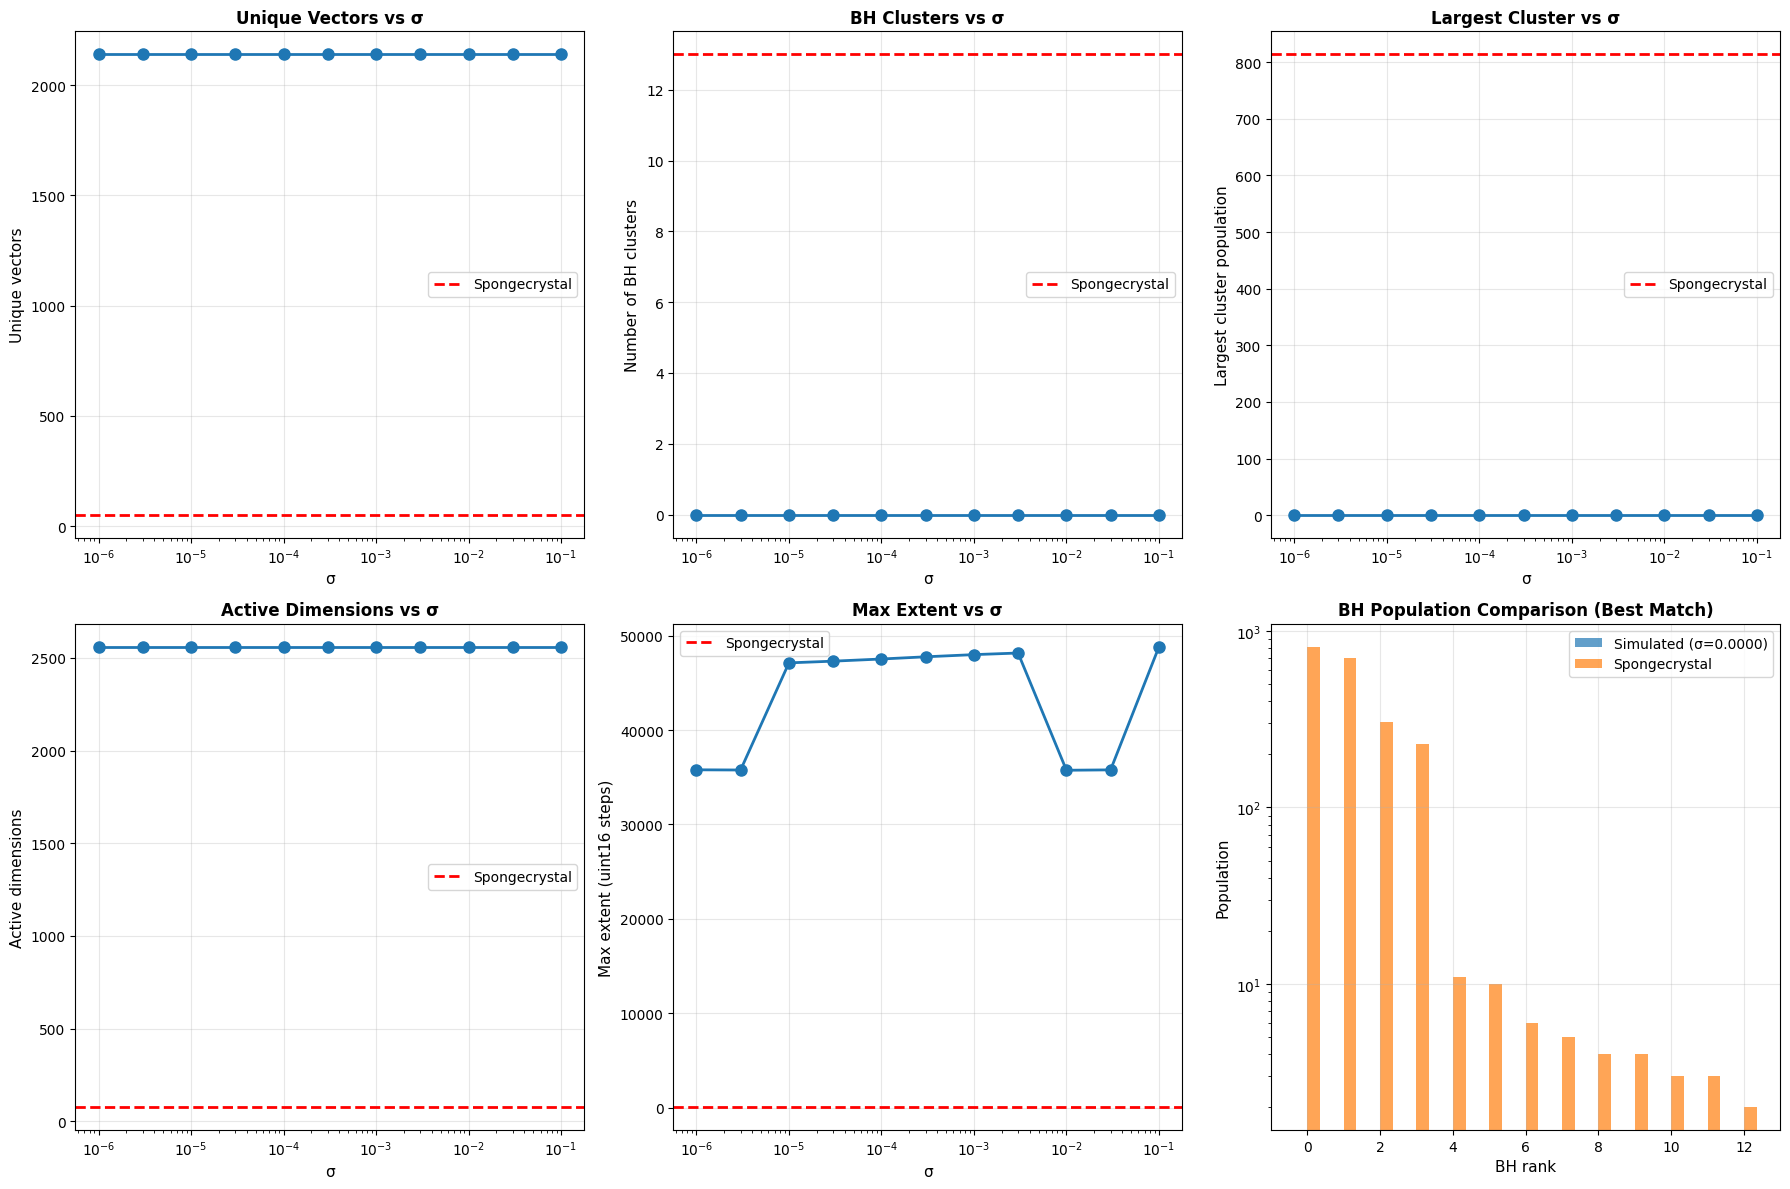

✓ Visualizations complete


In [15]:
print("\nCreating visualizations...\n")

fig = plt.figure(figsize=(18, 12), dpi=100)

# 1. Unique vectors vs σ
ax1 = plt.subplot(2, 3, 1)
sigmas_plot = [r['sigma'] for r in results]
uniques_plot = [r['n_unique'] for r in results]
ax1.plot(sigmas_plot, uniques_plot, 'o-', linewidth=2, markersize=8)
ax1.axhline(SPONGE_UNIQUE_VECTORS, color='red', linestyle='--', linewidth=2, label='Spongecrystal')
ax1.set_xscale('log')
ax1.set_xlabel('σ', fontsize=11)
ax1.set_ylabel('Unique vectors', fontsize=11)
ax1.set_title('Unique Vectors vs σ', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Number of BHs vs σ
ax2 = plt.subplot(2, 3, 2)
n_bhs_plot = [r['n_bhs'] for r in results]
ax2.plot(sigmas_plot, n_bhs_plot, 'o-', linewidth=2, markersize=8)
ax2.axhline(SPONGE_N_BHS, color='red', linestyle='--', linewidth=2, label='Spongecrystal')
ax2.set_xscale('log')
ax2.set_xlabel('σ', fontsize=11)
ax2.set_ylabel('Number of BH clusters', fontsize=11)
ax2.set_title('BH Clusters vs σ', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Largest cluster vs σ
ax3 = plt.subplot(2, 3, 3)
largest_plot = [r['largest_cluster'] for r in results]
ax3.plot(sigmas_plot, largest_plot, 'o-', linewidth=2, markersize=8)
ax3.axhline(SPONGE_LARGEST_CLUSTER, color='red', linestyle='--', linewidth=2, label='Spongecrystal')
ax3.set_xscale('log')
ax3.set_xlabel('σ', fontsize=11)
ax3.set_ylabel('Largest cluster population', fontsize=11)
ax3.set_title('Largest Cluster vs σ', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Active dimensions vs σ
ax4 = plt.subplot(2, 3, 4)
active_dims_plot = [r['n_active_dims'] for r in results]
ax4.plot(sigmas_plot, active_dims_plot, 'o-', linewidth=2, markersize=8)
ax4.axhline(SPONGE_ACTIVE_DIMS, color='red', linestyle='--', linewidth=2, label='Spongecrystal')
ax4.set_xscale('log')
ax4.set_xlabel('σ', fontsize=11)
ax4.set_ylabel('Active dimensions', fontsize=11)
ax4.set_title('Active Dimensions vs σ', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

# 5. Max extent vs σ
ax5 = plt.subplot(2, 3, 5)
max_extent_plot = [r['max_extent'] for r in results]
ax5.plot(sigmas_plot, max_extent_plot, 'o-', linewidth=2, markersize=8)
ax5.axhline(SPONGE_MAX_EXTENT, color='red', linestyle='--', linewidth=2, label='Spongecrystal')
ax5.set_xscale('log')
ax5.set_xlabel('σ', fontsize=11)
ax5.set_ylabel('Max extent (uint16 steps)', fontsize=11)
ax5.set_title('Max Extent vs σ', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(alpha=0.3)

# 6. BH population comparison (best match)
ax6 = plt.subplot(2, 3, 6)
sim_pops_plot = best['bh_populations'][:15]
actual_pops_plot = [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2]

x = np.arange(max(len(sim_pops_plot), len(actual_pops_plot)))
width = 0.35

# Pad with zeros if needed
sim_pops_padded = sim_pops_plot + [0] * (len(x) - len(sim_pops_plot))
actual_pops_padded = actual_pops_plot + [0] * (len(x) - len(actual_pops_plot))

ax6.bar(x - width/2, sim_pops_padded, width, label=f'Simulated (σ={best["sigma"]:.4f})', alpha=0.7)
ax6.bar(x + width/2, actual_pops_padded, width, label='Spongecrystal', alpha=0.7)
ax6.set_xlabel('BH rank', fontsize=11)
ax6.set_ylabel('Population', fontsize=11)
ax6.set_title('BH Population Comparison (Best Match)', fontsize=12, fontweight='bold')
ax6.set_yscale('log')
ax6.legend()
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualizations complete")

## Verdict

In [16]:
print("\n" + "=" * 100)
print("VERDICT: FLOAT32 → BFLOAT16 INITIALIZATION HYPOTHESIS")
print("=" * 100)
print()

# Compute best overall score
best_score = (
    min(best['n_unique'], SPONGE_UNIQUE_VECTORS) / max(best['n_unique'], SPONGE_UNIQUE_VECTORS) *
    (min(best['n_bhs'], SPONGE_N_BHS) / max(best['n_bhs'], SPONGE_N_BHS) if best['n_bhs'] > 0 else 0) *
    min(best['largest_cluster'], SPONGE_LARGEST_CLUSTER) / max(best['largest_cluster'], SPONGE_LARGEST_CLUSTER) *
    (min(best['n_active_dims'], SPONGE_ACTIVE_DIMS) / max(best['n_active_dims'], SPONGE_ACTIVE_DIMS) if best['n_active_dims'] > 0 else 0) *
    (min(best['max_extent'], SPONGE_MAX_EXTENT) / max(best['max_extent'], SPONGE_MAX_EXTENT) if best['max_extent'] > 0 else 0)
) ** (1/5)

print(f"Best match score: {best_score:.4f} (1.0 = perfect match)")
print()

if best_score > 0.8:
    print("✓ HYPOTHESIS SUPPORTED")
    print(f"  Float32 → bfloat16 initialization with σ = {best['sigma']:.4f} produces spongecrystal-like structures.")
    print("  Quantization clustering + random culling can explain the observed pattern.")
elif best_score > 0.5:
    print("~ HYPOTHESIS WEAKLY SUPPORTED")
    print(f"  Float32 → bfloat16 initialization with σ = {best['sigma']:.4f} produces somewhat similar structures.")
    print("  But significant differences remain. May need additional mechanisms.")
else:
    print("✗ HYPOTHESIS RULED OUT")
    print("  No σ value produces spongecrystal-like structures.")
    print("  Float32 → bfloat16 Gaussian initialization cannot explain the observed pattern.")
    print()
    print("Key mismatches:")
    
    if abs(best['n_unique'] - SPONGE_UNIQUE_VECTORS) > 20:
        print(f"  - Wrong number of unique vectors ({best['n_unique']} vs {SPONGE_UNIQUE_VECTORS})")
    
    if abs(best['n_bhs'] - SPONGE_N_BHS) > 5:
        print(f"  - Wrong number of BH clusters ({best['n_bhs']} vs {SPONGE_N_BHS})")
    
    if abs(best['largest_cluster'] - SPONGE_LARGEST_CLUSTER) > 300:
        print(f"  - Wrong largest cluster size ({best['largest_cluster']} vs {SPONGE_LARGEST_CLUSTER})")
    
    # Check population distribution shape
    if len(best['bh_populations']) >= 4:
        top4 = best['bh_populations'][:4]
        if all(abs(top4[i] - top4[i+1]) < 100 for i in range(3)):
            print(f"  - BH populations too uniform (actual has irregular 814, 704, 306, 228 pattern)")
    
    print()
    print("Conclusion: Need to explore other initialization hypotheses or training dynamics")

print()
print("=" * 100)


VERDICT: FLOAT32 → BFLOAT16 INITIALIZATION HYPOTHESIS

Best match score: 0.0000 (1.0 = perfect match)

✗ HYPOTHESIS RULED OUT
  No σ value produces spongecrystal-like structures.
  Float32 → bfloat16 Gaussian initialization cannot explain the observed pattern.

Key mismatches:
  - Wrong number of unique vectors (2139 vs 52)
  - Wrong number of BH clusters (0 vs 13)
  - Wrong largest cluster size (1 vs 814)

Conclusion: Need to explore other initialization hypotheses or training dynamics

